# Some Pymc3 tests
Let's try some common examples to warm up...
Look for reference in the __[official pmcy3 site](http://docs.pymc.io/notebooks/getting_started.html)__

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
from theano.tensor import _shared

In [2]:
mu = 0
sigma = 1
n = 10000
data = np.random.normal(loc=mu, scale=sigma, size=n)

In [3]:
data.shape

(10000,)

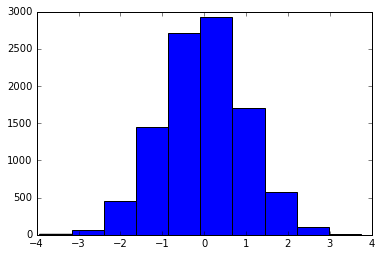

In [4]:
plt.hist(data)
plt.show()

In [5]:
with pm.Model() as model:
    mu = pm.Uniform('mu',-100,100)
    sd = pm.Uniform('sd',0,100)
    x = pm.Normal('x', mu=mu, sd=sd, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|██████████████████████████████████| 18000/18000 [00:05<00:00, 3104.07it/s]


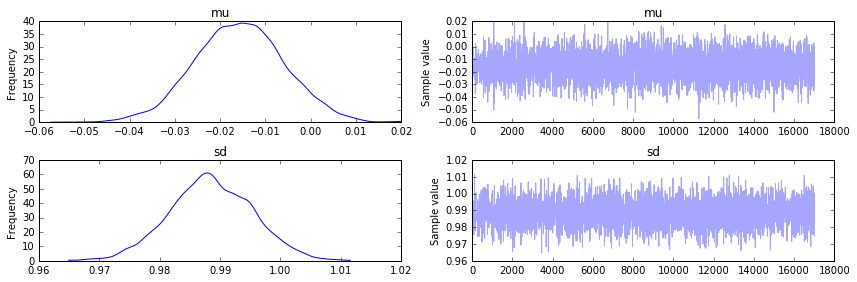

In [6]:
_=pm.traceplot(burned_trace)

In [7]:
print("mean:", burned_trace['mu'].mean(), "; Stddev:", burned_trace['sd'].mean())

mean: -0.0157062243148 ; Stddev: 0.988433980641


## Retention estimation for censored data
Let's see how to implement Fader's sBG distribution

In [66]:
example_data = np.array([1000, 869, 743, 653, 593, 551, 517, 491])
example_data = example_data * 1/1000.00 

In [67]:
def n_lost(data):
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

example_data_n_lost = n_lost(example_data)
n = len(example_data)
data = (example_data, example_data_n_lost)
data


(array([ 1.   ,  0.869,  0.743,  0.653,  0.593,  0.551,  0.517,  0.491]),
 [None,
  0.13100000000000001,
  0.126,
  0.089999999999999969,
  0.060000000000000053,
  0.041999999999999926,
  0.03400000000000003,
  0.026000000000000023])

In [68]:
data1=np.asarray(data)
data1[1,:]

array([None, 0.13100000000000001, 0.126, 0.089999999999999969,
       0.060000000000000053, 0.041999999999999926, 0.03400000000000003,
       0.026000000000000023], dtype=object)

In [69]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0.0001, 100)
    beta = pm.Uniform('beta', 0.0001, 100)
   
    def P_T_is_t(alpha=alpha, beta=beta, num_periods=n):
        p = np.array([None, alpha / (alpha + beta)])
        for t in range(2, num_periods):
            pt = ((beta + t - 2) / (alpha + beta + t - 1)) * p[t-1]
            p = np.append(p,pt)
        return p
    
    def survival_function(P_T_is_t=P_T_is_t, num_periods=n):
        p = P_T_is_t()
        s = [None, 1 - p[1]]
        for t in range(2, num_periods):
            s.append(s[t-1] - p[t])
        return s
    
    def logp(value):

        active = value[0,:]
        lost = value[1,:]
        
        # Those who've churned along the way...
        p = P_T_is_t()
        died = np.multiply(np.log(p[1:]), lost[1:]) 

        # and those still active in last period
        sf = survival_function()
        still_active = np.log(sf[-1]) * active[-1]              
        return sum(died) + still_active
   
    
    
    r = pm.DensityDist('r', logp, observed=data1)
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[5000:]


100%|██████████████████████████████████| 25000/25000 [00:05<00:00, 4654.12it/s]


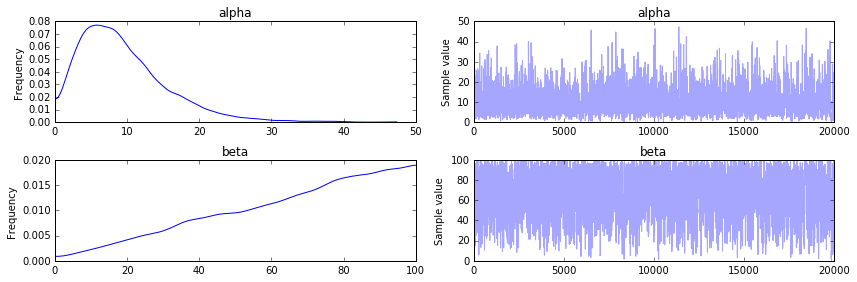

In [70]:
_=pm.traceplot(burned_trace)

In [72]:
burned_trace['alpha'].mean()

9.6066427525413332

In [73]:
burned_trace['beta'].mean()

66.234173812501936